In [82]:
import torch
import numpy as np 
import matplotlib.pyplot as plt

In [83]:
allTimeSeries=torch.load("data/192T/time_series.pt")
allMasks=torch.load("data/192T/masks.pt")
allDiffs=torch.load("data/192T/diffs.pt")
allLabels=torch.load("data/192T/labels.pt")

In [84]:
def calculateGlobalMean(variableNum, allTimeSeries, allDiffs):
    meanForPatientArray=[]
    
    #CHANGE TO 6261 TO ITERATE OVER ALL PATIENTS
    numOfPatients=1000
    
    for i in range(numOfPatients):
        timeSeriesForPatientAndVariable = np.asarray(allTimeSeries[i, ... , variableNum])
        diffForPatientAndVariable = np.asarray(allDiffs[i, ..., variableNum])
        if (diffForPatientAndVariable[191]>=3.9791667):
            #print('patient ', i, ' does not have any observations for variable ', variableNum)
            pass
        else:
            meanForPatient = np.mean(timeSeriesForPatientAndVariable, dtype ='float64')
            meanForPatientArray.append(meanForPatient)
    
    
    #CHANGE BOUNDS BELOW
    if(len(meanForPatientArray)<(.05*6261)): #(.05*numOfPatients)):      #if there are too few observations for this variable
        globalMean = 0.0                        
        #impute with zero because healthy ppl are not tested for this variable
        #print('LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE ', variableNum)
        #print('length for meanForPatientsArray: ', len(meanForPatientArray))
    else:
        globalMean = np.mean(meanForPatientArray, dtype ='float64')
    
    return globalMean

In [89]:
#IMPUTATION WITH MEAN OF ENTIRE TIME SEREIS

def impute_mean(allTimeSeries, allMasks, allDiffs):
    
    #CHANGE TO 6261 TO ITERATE OVER ALL PATIENTS' TIME SERIES
    numOfPatients = 1
    
    timeStepVector = [s for s in range(192)]
    allTimeSeriesAfterImputingTensor = torch.zeros(size=(numOfPatients, 192, 58))
    allMasksAfterImputingTensor = torch.zeros(size=(numOfPatients, 192, 58))
    allDiffsAfterImputingTensor = torch.zeros(size=(numOfPatients, 192, 58))

    for i in range(0, numOfPatients):                         #6261 is num of patients

        for j in range(59):                       #59 is num of variables
            
            if j==19:   
                #variable 19 (temperature) is unneccessray becuase it is same as variable 45 except it has more missing data
                pass
            
            else:
                oneTimeSeries = np.asarray(allTimeSeries[i, ..., j])
                oneMask = np.asarray(allMasks[i, ..., j])
                oneDiff = np.asarray(allDiffs[i, ..., j])
                print('patient num', i, 'variable number: ', j)
                realObservations = []                #vector with observed data values that are not outliers
                indexesOfRealObservations = []

                #fill up yVector with observed data values
                for k in range(192):
                    if (oneMask[k]==0.0):              #if datapoint is NOT originally missing
                        indexesOfRealObservations.append(k)
                        realObservations.append(oneTimeSeries[k])

                #calculating mean, standard deviation, bounds for outliers
                mean = np.mean(realObservations)
                sd = np.std(realObservations)
                upperBound = mean + 2*sd
                lowerBound = mean - 2*sd

                #finding outliers    
                indexesOfNoOutliersRealObservations = []
                noOutliersRealObservations = []
                for t in range(len(realObservations)):
                    indexesOfNoOutliersRealObservations.append(indexesOfRealObservations[t])
                    noOutliersRealObservations.append(realObservations[t])
                for m in range(len(realObservations)):
                    if (realObservations[m] > upperBound or realObservations[m] < lowerBound):
                        print('outlier tick')
                        indexOfOutlierInOriginalTS = indexesOfRealObservations[m]
                        print('outlier index in original TS: ', indexOfOutlierInOriginalTS)
                        indexesOfNoOutliersRealObservations.remove(indexOfOutlierInOriginalTS)
                        noOutliersRealObservations.remove(realObservations[m])
                    else:    #if this real observation is not an outlier
                        pass

                #imputing time series outliers and missing values with NEW mean, masks with 1.0, diffs with 0.0 ()
                if len(indexesOfRealObservations)==0:
                    globalMean=calculateGlobalMean(j, allTimeSeries, allDiffs)
                    oneTimeSeries.fill(globalMean)
                else:
                    mean = np.mean(noOutliersRealObservations)
                    for n in range(192):
                        if (n not in indexesOfNoOutliersRealObservations):    #if oneTimeSereis[n] is outlier or missing
                            oneTimeSeries[n] = mean
                            oneMask[n] = 1.0
                            if n==0:
                                oneDiff[n] = 0.0
                            else:
                                oneDiff[n] = oneDiff[n-1] + (1/48)
                                #print('it is doing what it is supposed to for timestep ' , n ,
                                #      '/n and value oneDiff[n] after getting updated is', oneDiff[n] )
                        else:                                                 #if it is not outlier or missing
                            oneDiff[n] = 0.0

                """          
                plotting time series with red dots representing real data points that are not outliers(points that were not imputed)
                plt.plot(timeStepVector, oneTimeSeries)
                if (len(realObservations)==0):
                    pass
                else:
                    plt.scatter(indexesOfNoOutliersRealObservations, noOutliersRealObservations, marker='o', color="red")
                plt.xlabel('time step')
                plt.ylabel('medical variable')
                plt.show()
                """

                #plotting timeseries, masks, and diffs
                plt.subplot(3,1,1)
                plt.plot(timeStepVector, oneTimeSeries)
                plt.title('Zero-Imputed Time Series')
                plt.ylabel('medical value')
                plt.xlabel('')

                plt.subplot(3,1,2)
                plt.scatter(timeStepVector, oneMask, color="red", s=1)
                plt.title('Missing Data: boolean variable')
                plt.ylabel('1=missing')
                plt.axis([0, 200, -.092, 1.092])
                plt.xlabel('')

                plt.subplot(3,1,3)
                plt.scatter(timeStepVector, oneDiff, c='green', s=1)
                plt.title('Time Step Difference Between Observations')
                plt.ylabel('count')
                plt.xlabel('time step')
                plt.tight_layout()
                plt.show()

                #putting vectors in original tensor shapes
                allTimeSeriesAfterImputingTensor[i, ..., j] = torch.from_numpy(np.asarray(oneTimeSeries))
                allMasksAfterImputingTensor[i, ..., j] = torch.from_numpy(np.asarray(oneMask))
                allDiffsAfterImputingTensor[i, ..., j] = torch.from_numpy(np.asarray(oneDiff))

    return allTimeSeriesAfterImputingTensor, allMasksAfterImputingTensor, allDiffsAfterImputingTensor

patient num 0 variable number:  0
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  0
length for meanForPatientsArray:  2


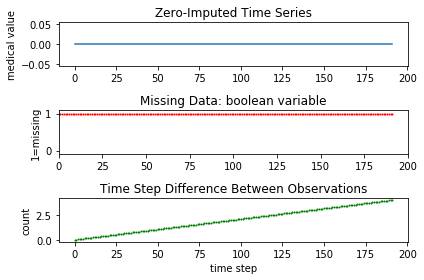

patient num 0 variable number:  1
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  1
length for meanForPatientsArray:  3


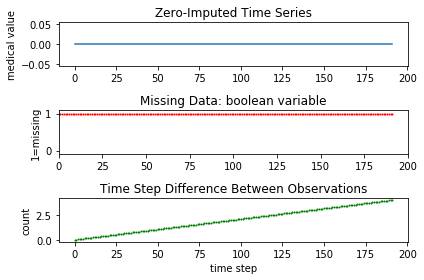

patient num 0 variable number:  2
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  2
length for meanForPatientsArray:  7


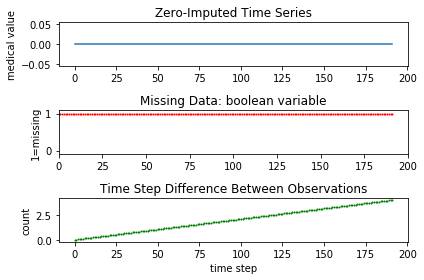

patient num 0 variable number:  3
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  3
length for meanForPatientsArray:  21


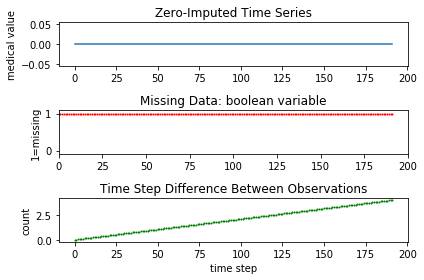

patient num 0 variable number:  4
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  4
length for meanForPatientsArray:  31


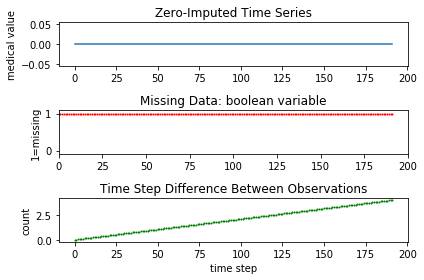

patient num 0 variable number:  5
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  5
length for meanForPatientsArray:  29


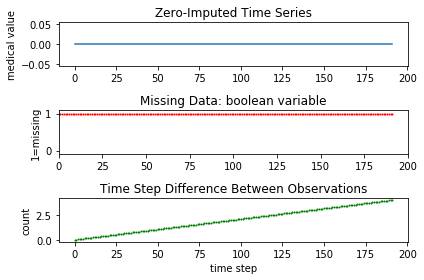

patient num 0 variable number:  6
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  6
length for meanForPatientsArray:  1


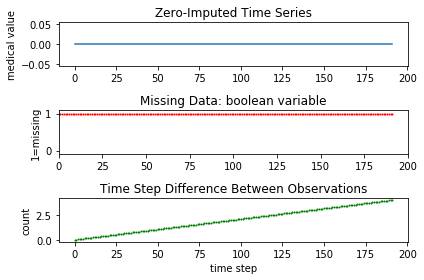

patient num 0 variable number:  7
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  7
length for meanForPatientsArray:  19


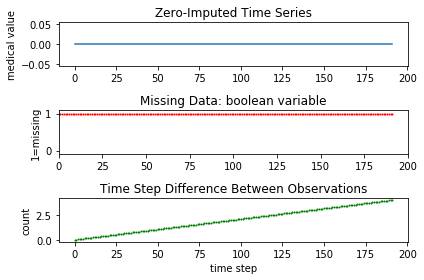

patient num 0 variable number:  8
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  8
length for meanForPatientsArray:  8


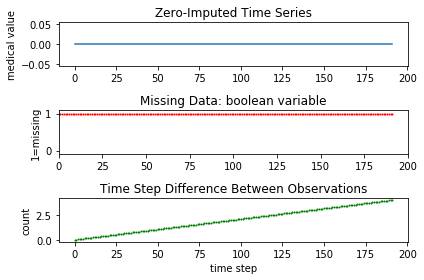

patient num 0 variable number:  9
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  9
length for meanForPatientsArray:  17


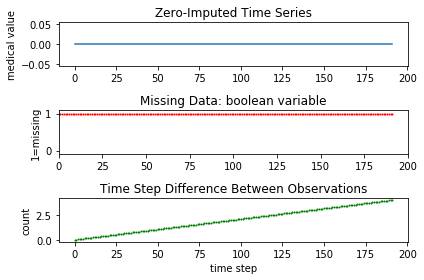

patient num 0 variable number:  10
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  10
length for meanForPatientsArray:  6


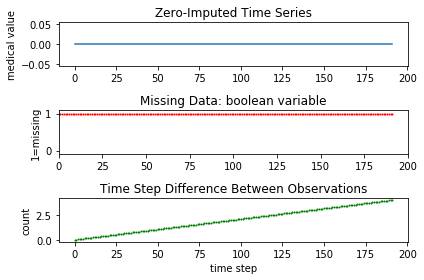

patient num 0 variable number:  11
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  11
length for meanForPatientsArray:  71


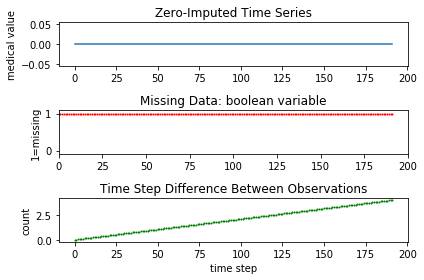

patient num 0 variable number:  12
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  12
length for meanForPatientsArray:  49


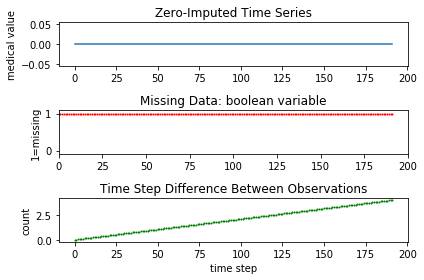

patient num 0 variable number:  13
LOOK INTO RESEARCHING TRUE VALUE FOR VARIABLE  13
length for meanForPatientsArray:  66


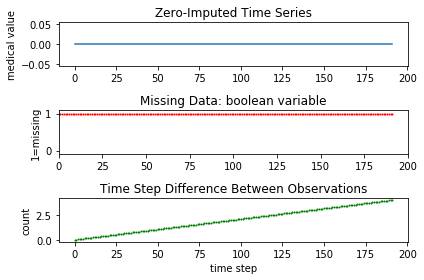

patient num 0 variable number:  14


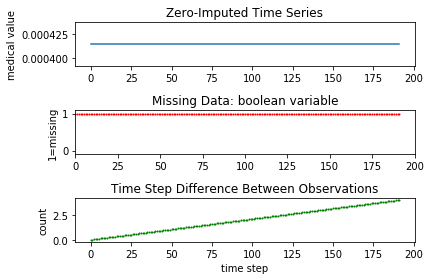

patient num 0 variable number:  15


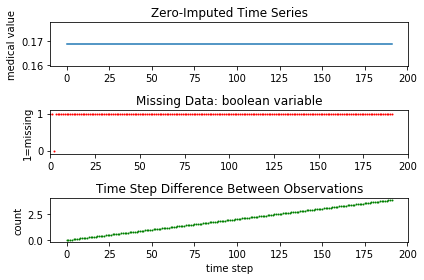

patient num 0 variable number:  16


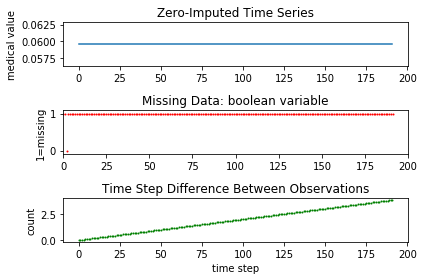

patient num 0 variable number:  17


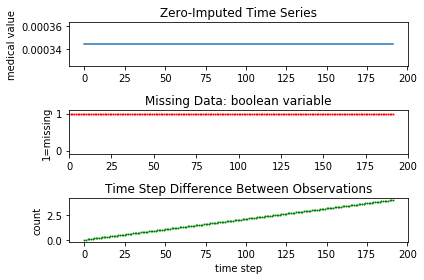

patient num 0 variable number:  18


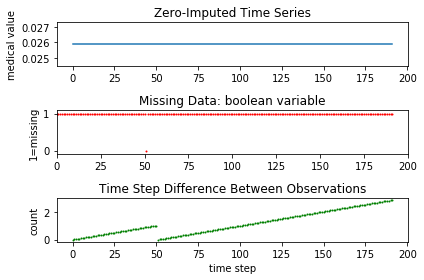

patient num 0 variable number:  20


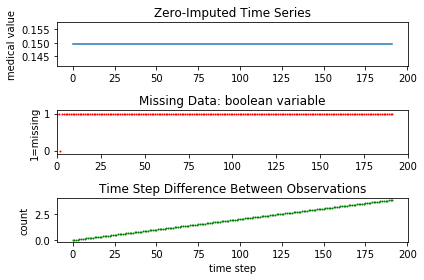

patient num 0 variable number:  21


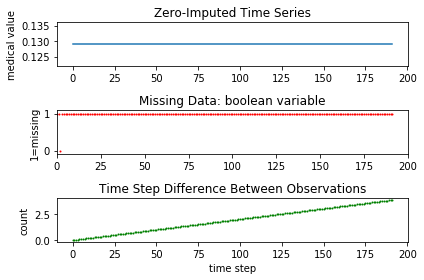

patient num 0 variable number:  22


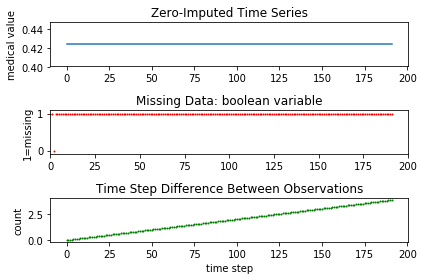

patient num 0 variable number:  23


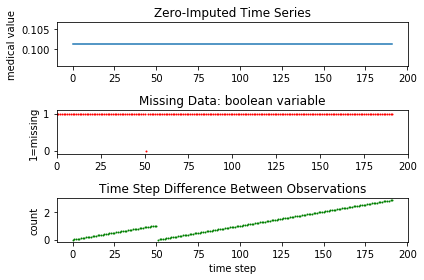

patient num 0 variable number:  24


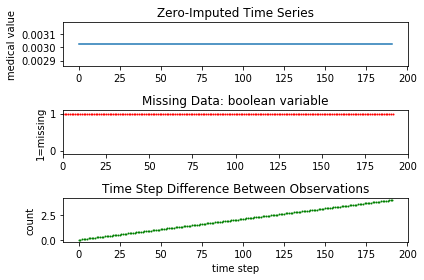

patient num 0 variable number:  25


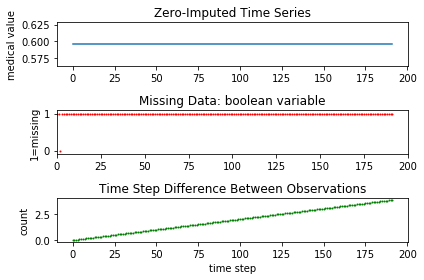

patient num 0 variable number:  26


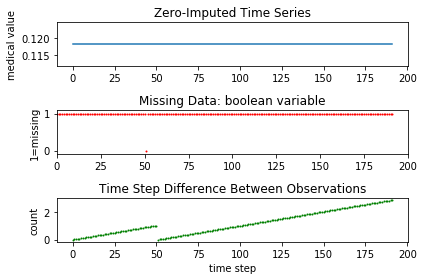

patient num 0 variable number:  27


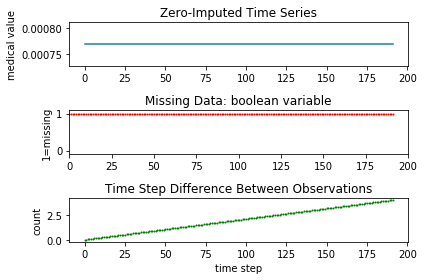

patient num 0 variable number:  28


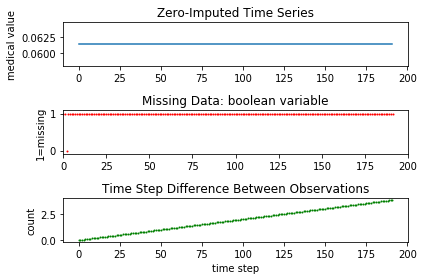

patient num 0 variable number:  29


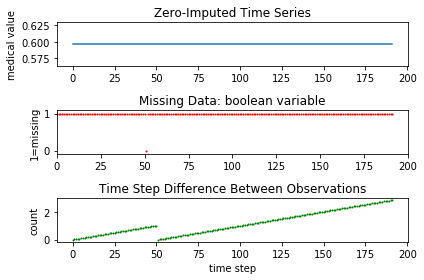

patient num 0 variable number:  30


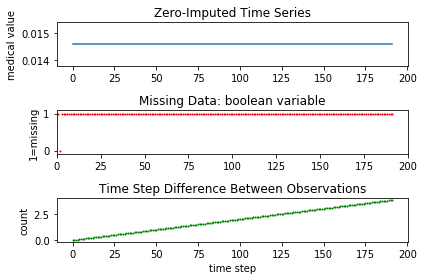

patient num 0 variable number:  31


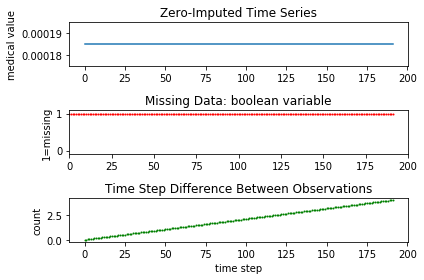

patient num 0 variable number:  32


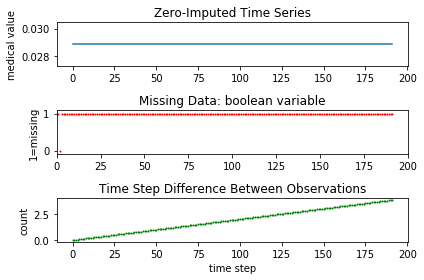

patient num 0 variable number:  33


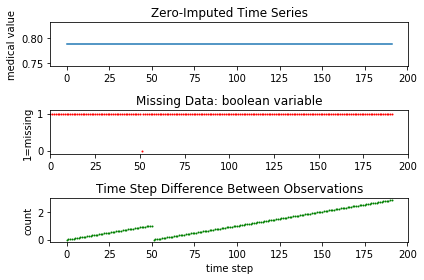

patient num 0 variable number:  34


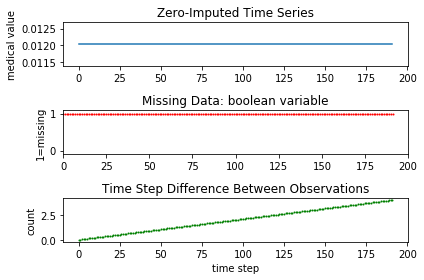

patient num 0 variable number:  35


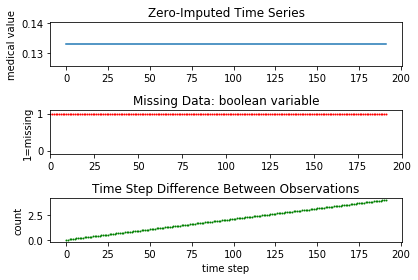

patient num 0 variable number:  36


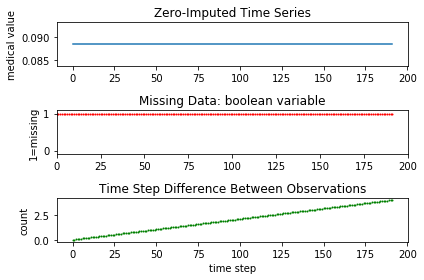

patient num 0 variable number:  37


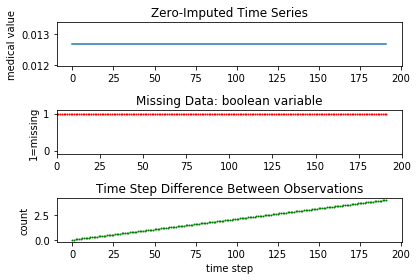

patient num 0 variable number:  38


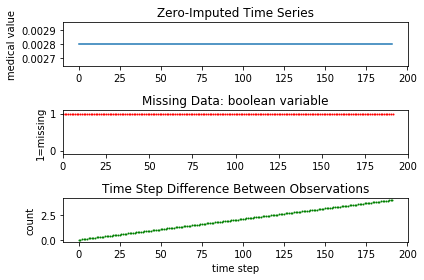

patient num 0 variable number:  39


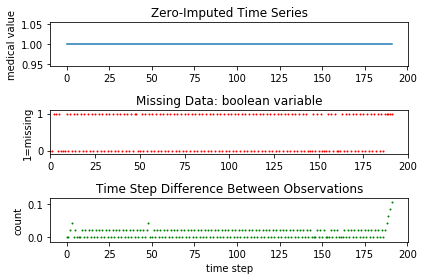

patient num 0 variable number:  40


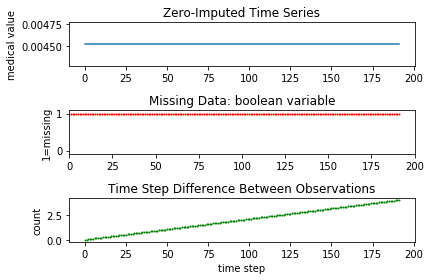

patient num 0 variable number:  41


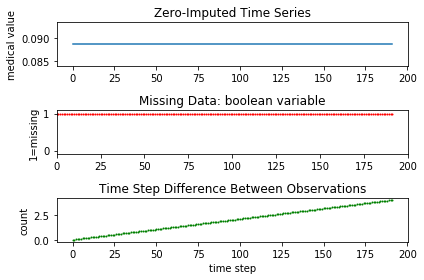

patient num 0 variable number:  42


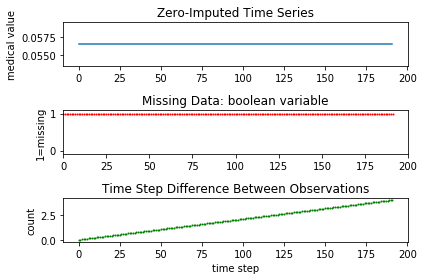

patient num 0 variable number:  43


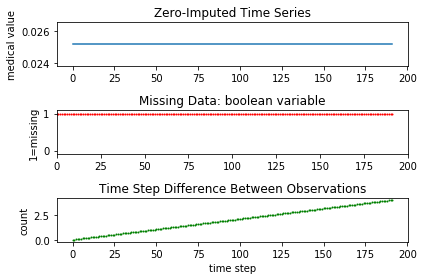

patient num 0 variable number:  44


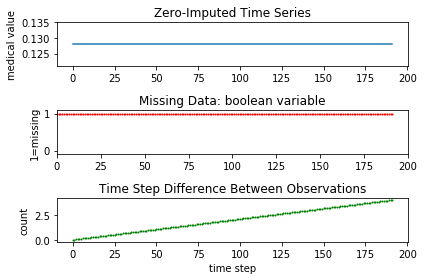

patient num 0 variable number:  45


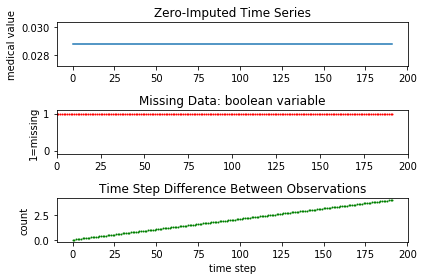

patient num 0 variable number:  46


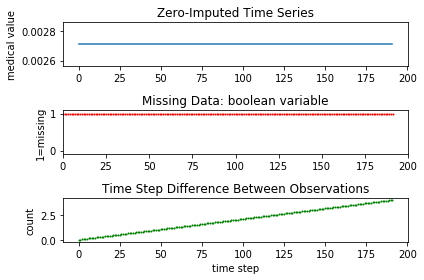

patient num 0 variable number:  47


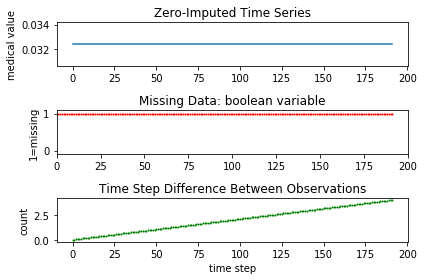

patient num 0 variable number:  48


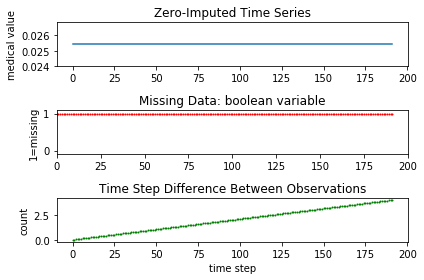

patient num 0 variable number:  49


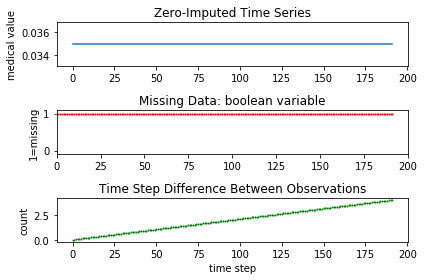

patient num 0 variable number:  50


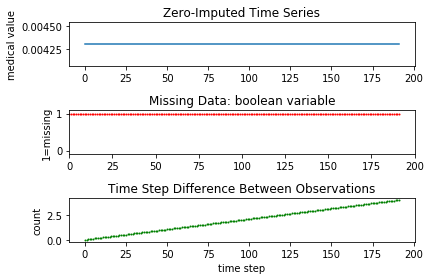

patient num 0 variable number:  51


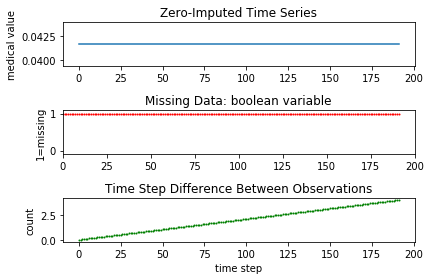

patient num 0 variable number:  52


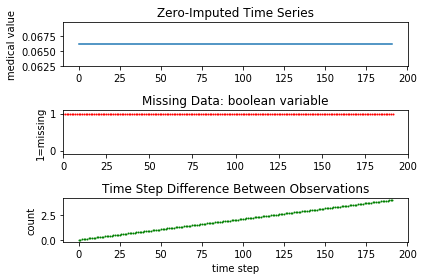

patient num 0 variable number:  53


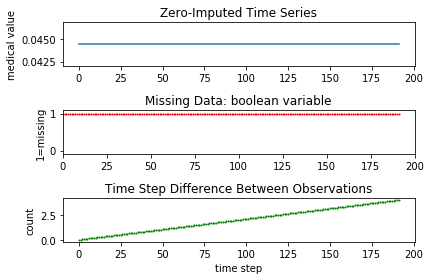

patient num 0 variable number:  54


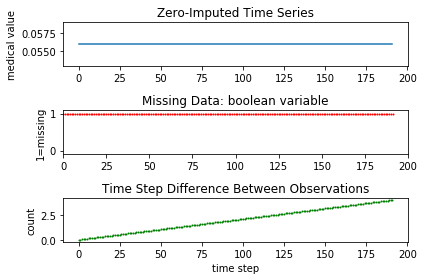

patient num 0 variable number:  55


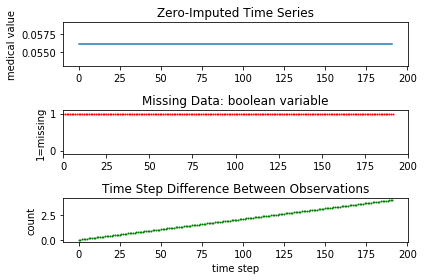

patient num 0 variable number:  56


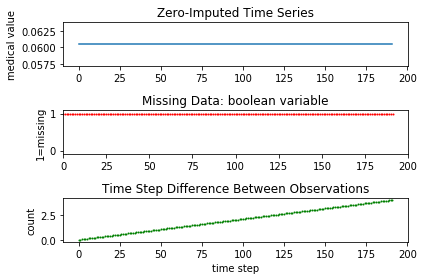

patient num 0 variable number:  57


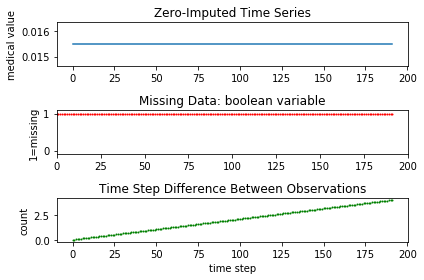

patient num 0 variable number:  58


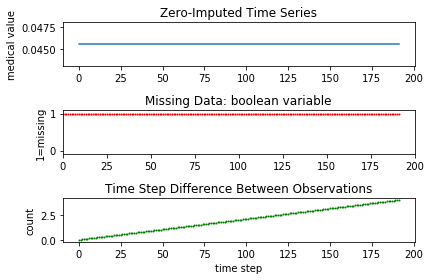

IndexError: index 58 is out of bounds for dimension 2 with size 58

In [90]:
out1, out2, out3 = impute_mean(allTimeSeries, allMasks, allDiffs)